# **Installation of Essential Libraries**

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

# Setup File Structure

In [20]:
# Load the dataset
data = pd.read_csv('/kaggle/input/multichannel-glaucoma-benchmark-dataset/metadata - standardized.csv', index_col=None)

# Setup Dataframes

In [21]:
# Function to append '.png' extension to file names
def append_ext(fn):
    return fn+".png"

# Select a subset of the dataset where 'fundus' column is not null and not equal to -1
fundus_subset = data[(data['fundus'].notnull()) & (data['fundus'] != -1)]

# Select only the relevant columns for further processing
fundus_subset = fundus_subset[['types', 'fundus', 'names']]

# Create a new column 'combined' by applying the 'append_ext' function to 'names' column
fundus_subset['combined'] = fundus_subset['names'].apply(append_ext)

# Convert 'fundus', 'types' columns to strings for further processing
fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
fundus_subset['types'] = fundus_subset['types'].astype(str)

In [22]:
# glaucoma fundus images
glaucomaCount = len(fundus_subset[(fundus_subset['types'] == '1')])
print(glaucomaCount)

# healthy fundus images
healthyCount = len(fundus_subset[(fundus_subset['types'] == '0')])
print(healthyCount)

# Randomize the data to create balanced training, validation, and testing sets
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# Separate the randomized data into a dataframe of healthy and glaucoma subsets
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

testSize = 500
valSize = 500
# get train items
healthy_train = healthy_subset.head(healthyCount - testSize - valSize)
glaucoma_train = glaucoma_subset.head(glaucomaCount - valSize)
train = healthy_train.append(glaucoma_train)

# get val items
healthy_val = healthy_subset.tail(valSize)
glaucoma_val = glaucoma_subset.tail(valSize)
val = healthy_val.append(glaucoma_val)

# get test items
healthy_test = healthy_subset.tail(testSize)
glaucoma_test = glaucoma_subset.tail(testSize)
test = healthy_test.append(glaucoma_test)

4767
7549


In [23]:
train.head()

,types,fundus,names,combined
1544,0,/full-fundus/OIA-ODIR-TRAIN-201.png,OIA-ODIR-TRAIN-201,OIA-ODIR-TRAIN-201.png
4648,0,/full-fundus/ORIGA-103.png,ORIGA-103,ORIGA-103.png
3383,0,/full-fundus/OIA-ODIR-TRAIN-2109.png,OIA-ODIR-TRAIN-2109,OIA-ODIR-TRAIN-2109.png
7977,0,/full-fundus/G1020-706.png,G1020-706,G1020-706.png
3631,0,/full-fundus/OIA-ODIR-TRAIN-2362.png,OIA-ODIR-TRAIN-2362,OIA-ODIR-TRAIN-2362.png


# Generate Data Batches for Training, Validation, and Testing


In [24]:
# Set target size and batch size for data generator
target = 224
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

# Create the training data generator
trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                            directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


# Create the validation data generator
valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                           directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus',   
                                           batch_size = batchSize, 
                                           class_mode = classes,
                                           shuffle=False, 
                                           x_col="combined", 
                                           y_col="types", 
                                           validate_filenames=True, 
                                           target_size=(target, target), 
                                           color_mode='rgb')


# Create the testing data generator
testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                           directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus',   
                                           batch_size = batchSize, 
                                           class_mode = classes,
                                           shuffle=False, 
                                           x_col="combined", 
                                           y_col="types", 
                                           validate_filenames=True, 
                                           target_size=(target, target), 
                                           color_mode='rgb')


Found 10816 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


# Generate Data Batches for Healthy_Subset and Glaucoma_Subset so it can be Visualized 


In [25]:
# Set class mode to 'sparse' for visualization data generators
classes = 'sparse'

# Create data generators for healthy and glaucoma subsets for visualization
healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
healthy_subset_Gen = trainDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                            directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                            directory='/kaggle/input/multichannel-glaucoma-benchmark-dataset/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [26]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

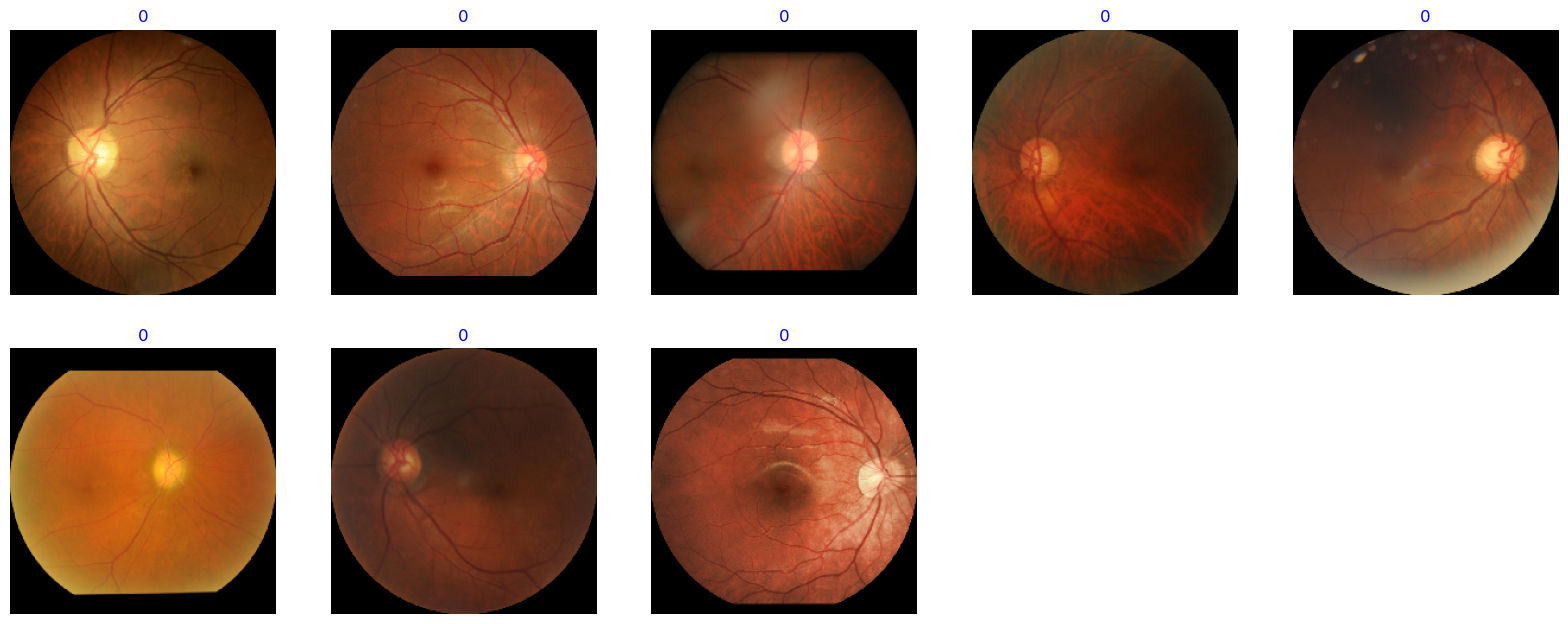

In [27]:
show_images(healthy_subset_Gen)

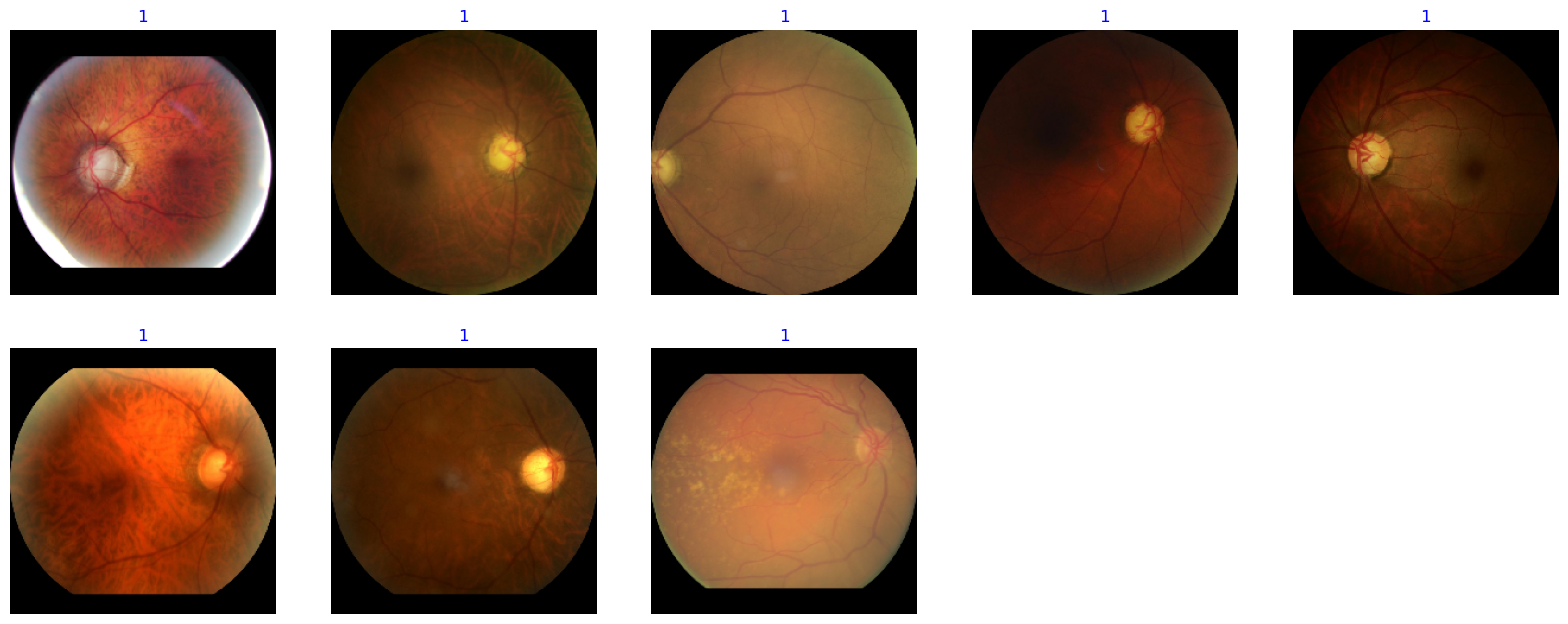

In [28]:
show_images(glaucoma_subset_Gen)

# Creating and Compiling the SVM Model

In [41]:
# define sequential model
svm_model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
svm_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid', input_shape = (224, 224, 3)))
svm_model.add(BatchNormalization(axis=3))
svm_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# define conv-pool layers - set 2
svm_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid'))

svm_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 3
svm_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
activation='relu', padding='valid'))
svm_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add flatten layer
svm_model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
svm_model.add(tf.keras.layers.Dense(512, activation='relu'))
svm_model.add(tf.keras.layers.Dropout(rate = 0.2))
svm_model.add(tf.keras.layers.Dense(256, activation='relu'))
svm_model.add(tf.keras.layers.Dense(256, activation='relu'))
svm_model.add(tf.keras.layers.Dense(128, activation='relu'))

# add output layer
svm_model.add(tf.keras.layers.Dense(1, kernel_regularizer = l2(0.01), #adding regularizer for svm, Because when we use Support Vector Machine for binary classification we use something called LinearSVM
activation='linear')) #use softmax as activation in the output layer
#for multiclass. Sigmoid activation is used for binary and 'relu' shouldnt be use for output layer

svm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 16)      4624      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 16)       0         
 g2D)                                                            
                                                      

In [43]:
#import modules that will wnable early stopping for optimization during model training
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime

#tensorboard
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

#define the early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [44]:
# Define the F1 score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())


In [45]:
svm_model.compile(optimizer = 'adam',
            loss = 'squared_hinge',
            metrics=['accuracy','Precision','Recall','AUC',f1_score_metric])

r=svm_model.fit(trainGen,
            batch_size = 32,
            verbose = 1, # Suppress chatty output; use Tensorboard instead
            epochs = 10,
            validation_data = valGen, #add the validation set to evaluate the performance in each run
            callbacks = [tensorboard_callback, es],)

Epoch 1/10
1352/1352 [==============================] - 202s 146ms/step - loss: 0.8414 - accuracy: 0.6783 - precision: 0.8523 - recall: 0.2231 - auc: 0.7107 - f1_score_metric: 162722.0312 - val_loss: 0.7213 - val_accuracy: 0.5860 - val_precision: 0.9479 - val_recall: 0.1820 - val_auc: 0.7487 - val_f1_score_metric: 0.1209
Epoch 2/10
1352/1352 [==============================] - 116s 86ms/step - loss: 0.6449 - accuracy: 0.7433 - precision: 0.9084 - recall: 0.3883 - auc: 0.7669 - f1_score_metric: 650887.5625 - val_loss: 0.6465 - val_accuracy: 0.7750 - val_precision: 0.8940 - val_recall: 0.6240 - val_auc: 0.8231 - val_f1_score_metric: 0.4257
Epoch 3/10
1352/1352 [==============================] - 116s 85ms/step - loss: 0.5739 - accuracy: 0.7763 - precision: 0.9293 - recall: 0.4685 - auc: 0.7959 - f1_score_metric: 1375739.6250 - val_loss: 0.7471 - val_accuracy: 0.6910 - val_precision: 0.9704 - val_recall: 0.3940 - val_auc: 0.7516 - val_f1_score_metric: 0.1206
Epoch 4/10
1352/1352 [==========

In [47]:
# Evaluate the model on the validation data
score=svm_model.evaluate(valGen)
score

125/125 [==============================] - 9s 75ms/step - loss: 0.5950 - accuracy: 0.7090 - precision: 0.9906 - recall: 0.4220 - auc: 0.8081 - f1_score_metric: 0.2721


[0.5950140953063965,
 0.7089999914169312,
 0.9906103014945984,
 0.421999990940094,
 0.8081440329551697,
 0.2721322774887085]

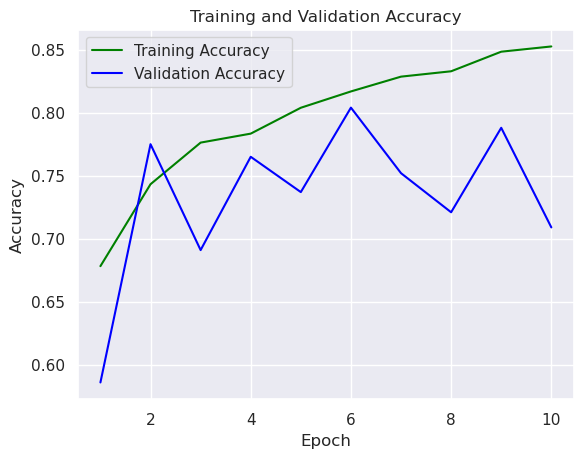

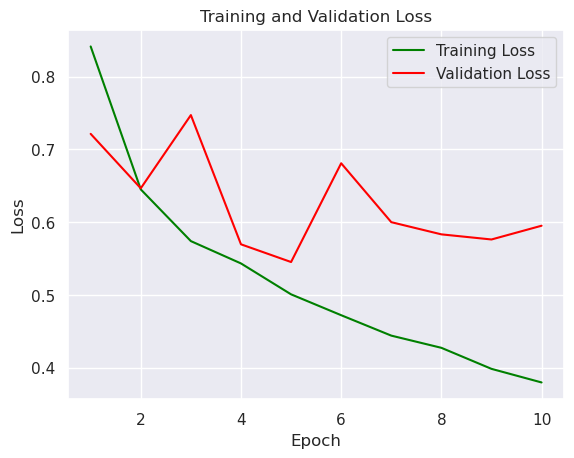

In [49]:
# Plot the training and validation accuracy and loss
import seaborn as sns
sns.set()

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [50]:
prediction = svm_model.predict_generator(testGen, verbose=1)


/tmp/ipykernel_29/1969852277.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = svm_model.predict_generator(testGen, verbose=1)


125/125 [==============================] - 10s 78ms/step
